<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h2>Objective:</h2>
    <h3> Applying Logistic regression on top features obtained from Count Vectorizer (Unigrams and Bigrams). </h3>
    <h3> As this task involves CV with LR, removed all the extra code not required for this task </h3>

<h2>All the results are obtained from Tf_Idf vectorizing of features</h2>
<h3>Findings: </h3>
<table style=width:80%>
  <tr>
    <th>Model Name</th>
    <th>Log Loss Train</th> 
    <th>Log Loss CV</th>
    <th>Log Loss Test</th>
    <th>% of Misclassified Points</th>  
  </tr>
  <tr>
    <td>CV with Unigram</td>
    <td>0.455</td> 
    <td>1.112</td>
    <td>1.030</td>
    <td>35.52</td>  
  </tr>
  <tr>
    <td>CV with Bigram</td>
    <td>0.546</td> 
    <td>1.169</td>
    <td>1.107</td>
    <td>36.27</td>  
  </tr>
  
</table>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

C:\Users\rahul\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h3>1. Reading Data </h3>

In [2]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

In [3]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>2. Pre Processing of Data</h3>

In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        # replace every special char with space
        if type(total_text) is not float:
            string = ""
            total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
            # replace multiple spaces with single space
            total_text = re.sub('\s+',' ', total_text)
            # converting all the chars into lower-case.
            total_text = total_text.lower()

            for word in total_text.split():
            # if the word is a not a stop word then retain that word from the data
                if not word in stop_words:
                    string += word + " "

            data_text[column][index] = string

In [5]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 247.15171131059137 seconds


In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


<h3>2.1. Test, Train and Cross Validation Split</h3>

In [18]:
import math
for i in np.array(np.where(result['TEXT'].isnull().values==True)):
    result['TEXT'][i]='empty'

In [19]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [20]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [21]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
   
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [11]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [12]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

<h1>3.0 Applying LR with Unigram and Bigram CountVectorizer</h1>

In [29]:
def get_impfeature_names(indices, text, gene, var, no_features,gene_vec,var_vec,text_vec):
    gene_vec = gene_vec.fit(train_df['Gene'])
    var_vec  = var_vec.fit(train_df['Variation'])
    text_vec = text_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [14]:
def getVectorizers(countVec):
    gene_vectorizer = CountVectorizer()
    variation_vectorizer = CountVectorizer()
    if countVec == 'unigram':
        text_vectorizer = CountVectorizer(min_df=3)
    elif countVec == 'bigram':
        text_vectorizer = CountVectorizer(ngram_range=(1, 2),min_df=3)

    return  gene_vectorizer,variation_vectorizer,text_vectorizer

In [15]:
def get_train_test_cv(gene_vectorizer,variation_vectorizer,text_vectorizer):    
    train_gene_feature = gene_vectorizer.fit_transform(train_df['Gene'])
    test_gene_feature = gene_vectorizer.transform(test_df['Gene'])
    cv_gene_feature = gene_vectorizer.transform(cv_df['Gene'])

   
    train_variation_feature = variation_vectorizer.fit_transform(train_df['Variation'])
    test_variation_feature = variation_vectorizer.transform(test_df['Variation'])
    cv_variation_feature = variation_vectorizer.transform(cv_df['Variation'])

    train_text_feature = text_vectorizer.fit_transform(train_df['TEXT'])
    train_text_feature = normalize(train_text_feature, axis=0)

    test_text_feature = text_vectorizer.transform(test_df['TEXT'])
    test_text_feature = normalize(test_text_feature, axis=0)

    cv_text_feature = text_vectorizer.transform(cv_df['TEXT'])
    cv_text_feature = normalize(cv_text_feature, axis=0)

    train_gene_var = hstack((train_gene_feature,train_variation_feature))
    test_gene_var = hstack((test_gene_feature,test_variation_feature))
    cv_gene_var = hstack((cv_gene_feature,cv_variation_feature))

    train_x = hstack((train_gene_var, train_text_feature)).tocsr()
    train_y = np.array(list(train_df['Class']))

    test_x = hstack((test_gene_var, test_text_feature)).tocsr()
    test_y = np.array(list(test_df['Class']))

    cv_x = hstack((cv_gene_var, cv_text_feature)).tocsr()
    cv_y = np.array(list(cv_df['Class']))
    print('Shape of data (Train, CV, Test ) : (%s, %s, %s) ' %(train_x.shape,cv_x.shape,test_x.shape))
    return train_x,cv_x,test_x,train_y,cv_y,test_y

In [24]:
def logisticRegression(train_x,cv_x,test_x,train_y,cv_y,test_y):
    alpha = [10**-4, 10**-2, 10**0, 10**2, 10**4]
    #alpha = [10**-2, 10**2]
    cv_log_error_array = []
    for i in alpha:
        print("for alpha =", i)
        clf = LogisticRegression(class_weight='balanced', C=i, penalty='l2',random_state=42)
        clf.fit(train_x, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        # to avoid rounding error while multiplying probabilites we use log-probability estimates
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

    fig, ax = plt.subplots()
    ax.plot(alpha, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()


    best_alpha = np.argmin(cv_log_error_array)
    clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l2',random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)

    predict_y = sig_clf.predict_proba(train_x)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(cv_x)
    print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(test_x)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>3.1 Unigram CountVectorizer</h3>

In [22]:
gene_vectorizer,variation_vectorizer,text_vectorizer=getVectorizers('unigram')
train_x,cv_x,test_x,train_y,cv_y,test_y=get_train_test_cv(gene_vectorizer,variation_vectorizer,text_vectorizer)

Shape of data (Train, CV, Test ) : ((2124, 54735), (532, 54735), (665, 54735)) 


for alpha = 0.0001
Log Loss : 1.7092608671216254
for alpha = 0.01
Log Loss : 1.3144416891079727
for alpha = 1
Log Loss : 1.1272895058167682
for alpha = 100
Log Loss : 1.1127787751905125
for alpha = 10000
Log Loss : 1.1188376579181802


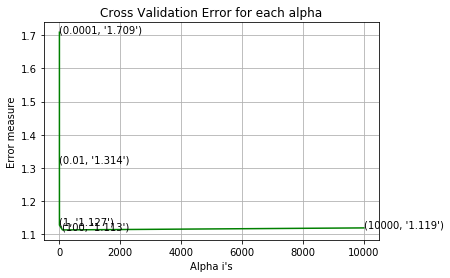

For values of best alpha =  100 The train log loss is: 0.45599444707894204
For values of best alpha =  100 The cross validation log loss is: 1.1127787751905125
For values of best alpha =  100 The test log loss is: 1.0306930156102145


In [25]:
logisticRegression(train_x,cv_x,test_x,train_y,cv_y,test_y)

Log loss : 1.1127787751905125
Number of mis-classified points : 0.35526315789473684
-------------------- Confusion matrix --------------------


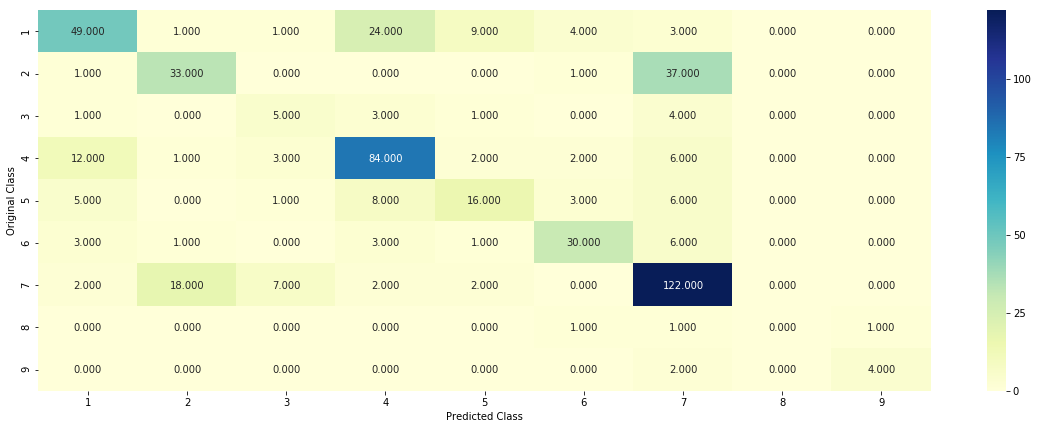

-------------------- Precision matrix (Columm Sum=1) --------------------


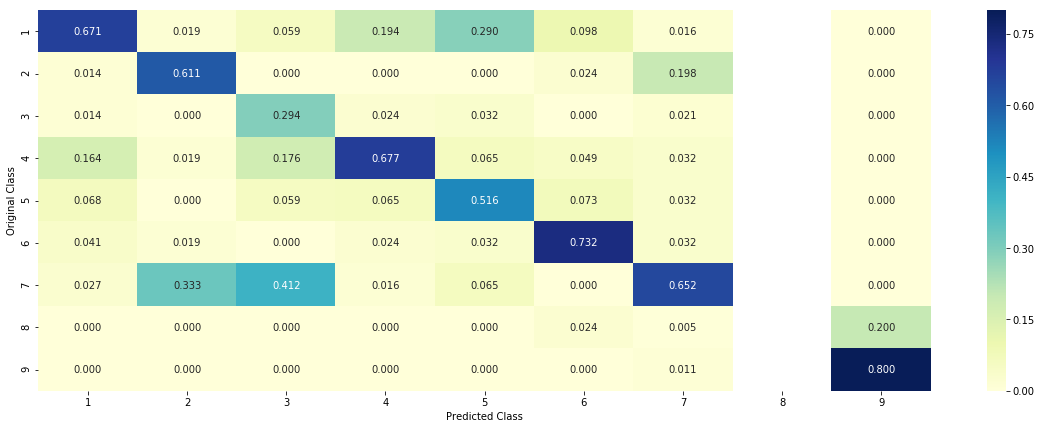

-------------------- Recall matrix (Row sum=1) --------------------


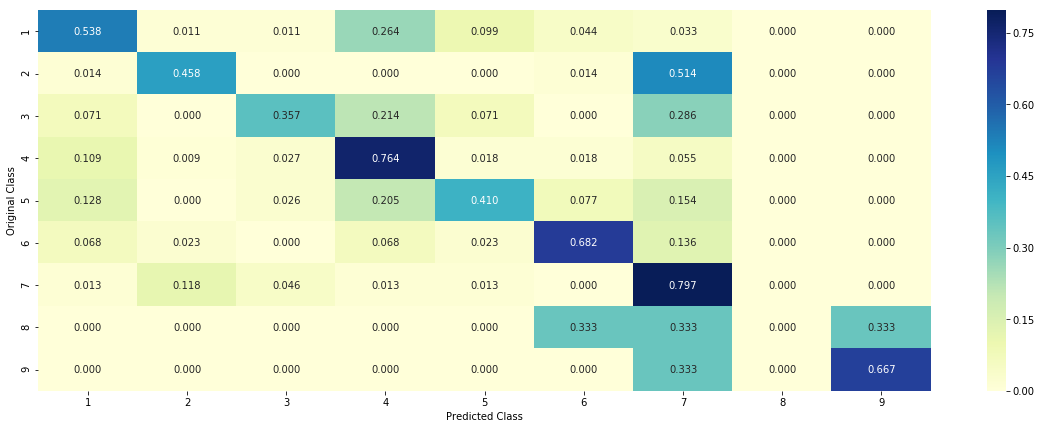

In [26]:
clf = LogisticRegression(class_weight='balanced', C=100, penalty='l2',random_state=42)
predict_and_plot_confusion_matrix(train_x, train_y, cv_x, cv_y, clf)

In [27]:
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
            cv=3, method='sigmoid')

In [30]:
# from tabulate import tabulate
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index],no_feature,gene_vectorizer,variation_vectorizer,text_vectorizer)

Predicted Class : 7
Predicted Class Probabilities: [[0.0835 0.311  0.0117 0.0541 0.0414 0.0496 0.4352 0.0071 0.0062]]
Actual Class : 2
--------------------------------------------------
444 Text feature [technology] present in test data point [True]
466 Text feature [turnaround] present in test data point [True]
481 Text feature [gauge] present in test data point [True]
Out of the top  500  features  3 are present in query point


<h3>3.2 Bigram CountVectorizer</h3>

In [32]:
gene_vectorizer,variation_vectorizer,text_vectorizer=getVectorizers('bigram')
train_x,cv_x,test_x,train_y,cv_y,test_y=get_train_test_cv(gene_vectorizer,variation_vectorizer,text_vectorizer)

Shape of data (Train, CV, Test ) : ((2124, 763823), (532, 763823), (665, 763823)) 


for alpha = 0.0001
Log Loss : 1.3952511571592925
for alpha = 0.01
Log Loss : 1.3050329137854657
for alpha = 1
Log Loss : 1.1840181221869075
for alpha = 100
Log Loss : 1.1690474473885097
for alpha = 10000
Log Loss : 1.1697170403798005


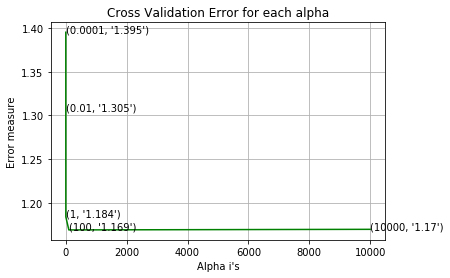

For values of best alpha =  100 The train log loss is: 0.5468407662298126
For values of best alpha =  100 The cross validation log loss is: 1.1690474473885097
For values of best alpha =  100 The test log loss is: 1.1075697109666884


In [33]:
logisticRegression(train_x,cv_x,test_x,train_y,cv_y,test_y)

Log loss : 1.1690474473885097
Number of mis-classified points : 0.36278195488721804
-------------------- Confusion matrix --------------------


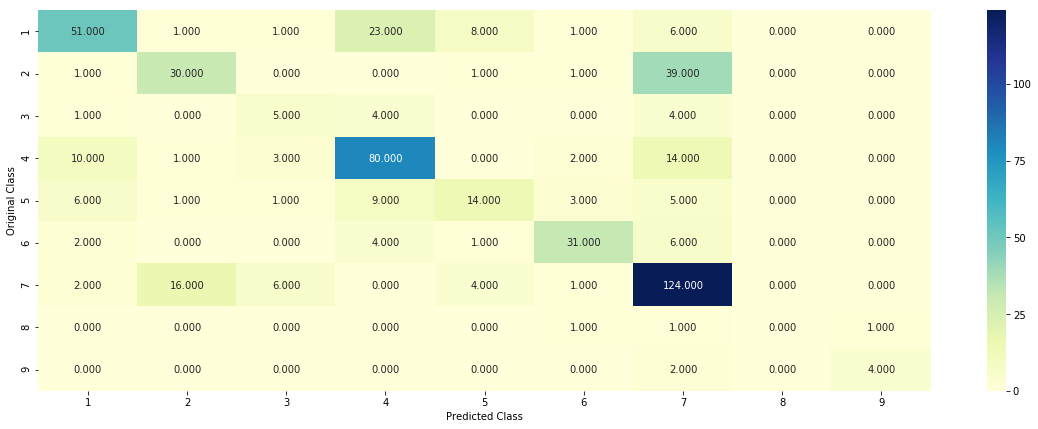

-------------------- Precision matrix (Columm Sum=1) --------------------


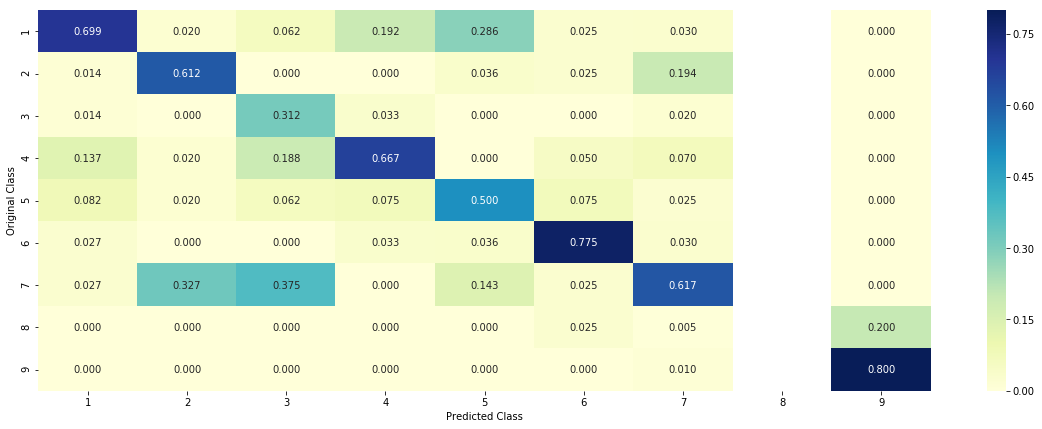

-------------------- Recall matrix (Row sum=1) --------------------


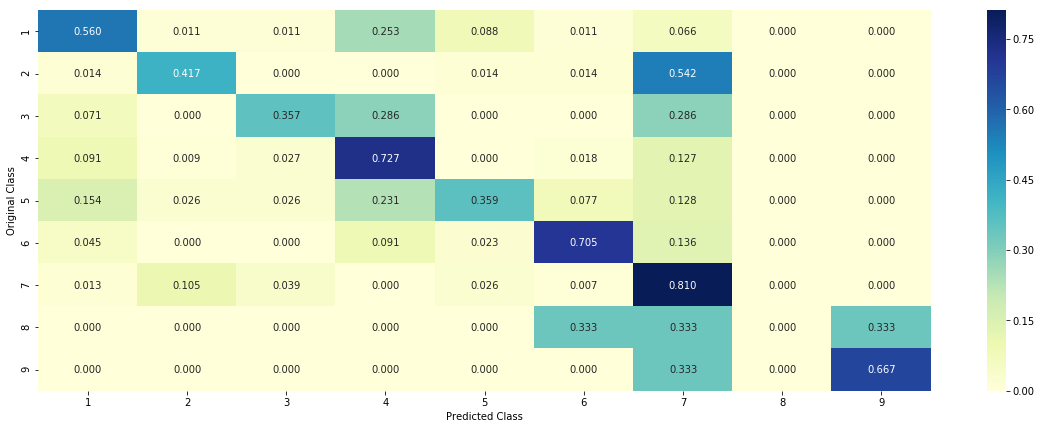

In [34]:
clf = LogisticRegression(class_weight='balanced', C=100, penalty='l2',random_state=42)
predict_and_plot_confusion_matrix(train_x, train_y, cv_x, cv_y, clf)

In [35]:
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
            cv=3, method='sigmoid')

In [36]:
# from tabulate import tabulate
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index],no_feature,gene_vectorizer,variation_vectorizer,text_vectorizer)

Predicted Class : 7
Predicted Class Probabilities: [[0.1463 0.2359 0.0195 0.1277 0.0577 0.0869 0.3066 0.0088 0.0104]]
Actual Class : 2
--------------------------------------------------
Out of the top  500  features  0 are present in query point
